rewards:
---------------------------
-0.90|-0.90|-0.90| 1.00|
---------------------------
-0.90| 0.00|-0.90|-1.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


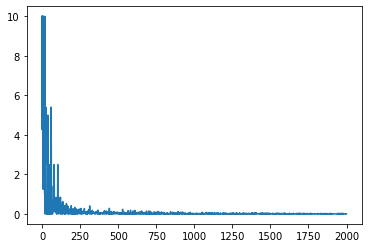

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  U  |
final values:
---------------------------
-1.79|-0.88| 1.00| 0.00|
---------------------------
-2.58| 0.00|-0.72| 0.00|
---------------------------
-3.21|-2.79|-1.75|-1.00|


In [1]:
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy

GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# NOTE: this script implements the Monte Carlo Exploring-Starts method
#       for finding the optimal policy

def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this if we have a deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  # this is called the "exploring starts" method
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  seen_states = set()
  seen_states.add(grid.current_state())
  num_steps = 0
  while True:
    r = grid.move(a)
    num_steps += 1
    s = grid.current_state()

    if s in seen_states:
      # hack so that we don't end up in an infinitely long episode
      # bumping into the wall repeatedly
      # if num_steps == 1 -> bumped into a wall and haven't moved anywhere
      #   reward = -10
      # else:
      #   reward = falls off by 1 / num_steps
      reward = -10. / num_steps
      states_actions_rewards.append((s, None, reward))
      break
    elif grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = policy[s]
      states_actions_rewards.append((s, a, r))
    seen_states.add(s)

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns


def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  # grid = standard_grid()
  # try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  grid = negative_grid(step_cost=-0.9)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initialize Q(s,a) and returns
  Q = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0 # needs to be initialized to something so we can argmax it
        returns[(s,a)] = []
    else:
      # terminal state or state we can't otherwise get to
      pass

  # repeat until convergence
  deltas = []
  for t in range(2000):
    if t % 100 == 0:
      print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      sa = (s, a)
      if sa not in seen_state_action_pairs:
        old_q = Q[s][a]
        returns[sa].append(G)
        Q[s][a] = np.mean(returns[sa])
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
        seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # update policy
    for s in policy.keys():
      policy[s] = max_dict(Q[s])[0]

  plt.plot(deltas)
  plt.show()

  print("final policy:")
  print_policy(policy, grid)

  # find V
  V = {}
  for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)

